In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import argparse
import time
import msgpack
from enum import Enum, auto

import numpy as np

from voxmap import create_voxmap
from planning_utils import a_star, heuristic, create_grid
from planning_utils import a_star3D, heuristic3D, heuristic2D
from udacidrone import Drone
from udacidrone.connection import MavlinkConnection
from udacidrone.messaging import MsgID
from udacidrone.frame_utils import global_to_local

In [5]:
import matplotlib.pyplot as plt

%matplotlib inline

In [6]:
class States(Enum):
    MANUAL = auto()
    ARMING = auto()
    TAKEOFF = auto()
    WAYPOINT = auto()
    LANDING = auto()
    DISARMING = auto()
    PLANNING = auto()

In [7]:
class MotionPlanning(Drone):

    def __init__(self, connection):
        super().__init__(connection)

        self.target_position = np.array([0.0, 0.0, 0.0])
        self.waypoints = []
        self.in_mission = True
        self.check_state = {}

        # initial state
        self.flight_state = States.MANUAL

        # register all your callbacks here
        self.register_callback(MsgID.LOCAL_POSITION, self.local_position_callback)
        self.register_callback(MsgID.LOCAL_VELOCITY, self.velocity_callback)
        self.register_callback(MsgID.STATE, self.state_callback)

    def local_position_callback(self):
        if self.flight_state == States.TAKEOFF:
            if -1.0 * self.local_position[2] > 0.95 * self.target_position[2]:
                self.waypoint_transition()
        elif self.flight_state == States.WAYPOINT:
            if np.linalg.norm(self.target_position[0:2] - self.local_position[0:2]) < 1.0:
                if len(self.waypoints) > 0:
                    self.waypoint_transition()
                else:
                    if np.linalg.norm(self.local_velocity[0:2]) < 1.0:
                        self.landing_transition()

    def velocity_callback(self):
        if self.flight_state == States.LANDING:
            if self.global_position[2] - self.global_home[2] < 0.1:
                if abs(self.local_position[2]) < 0.01:
                    self.disarming_transition()

    def state_callback(self):
        if self.in_mission:
            if self.flight_state == States.MANUAL:
                self.arming_transition()
            elif self.flight_state == States.ARMING:
                if self.armed:
                    self.plan_path()
            elif self.flight_state == States.PLANNING:
                self.takeoff_transition()
            elif self.flight_state == States.DISARMING:
                if ~self.armed & ~self.guided:
                    self.manual_transition()

    def arming_transition(self):
        self.flight_state = States.ARMING
        print("arming transition")
        self.arm()
        self.take_control()

    def takeoff_transition(self):
        self.flight_state = States.TAKEOFF
        print("takeoff transition")
        self.takeoff(self.target_position[2])

    def waypoint_transition(self):
        self.flight_state = States.WAYPOINT
        print("waypoint transition")
        self.target_position = self.waypoints.pop(0)
        print('target position', self.target_position)
        self.cmd_position(self.target_position[0], self.target_position[1], self.target_position[2], self.target_position[3])

    def landing_transition(self):
        self.flight_state = States.LANDING
        print("landing transition")
        self.land()

    def disarming_transition(self):
        self.flight_state = States.DISARMING
        print("disarm transition")
        self.disarm()
        self.release_control()

    def manual_transition(self):
        self.flight_state = States.MANUAL
        print("manual transition")
        self.stop()
        self.in_mission = False

    def send_waypoints(self):
        print("Sending waypoints to simulator ...")
        data = msgpack.dumps(self.waypoints)
        self.connection._master.write(data)

    def plan_path(self):
        self.flight_state = States.PLANNING
        print("Searching for a path ...")
        TARGET_ALTITUDE = 5
        SAFETY_DISTANCE = 5

        self.target_position[2] = TARGET_ALTITUDE

        # TODO: read lat0, lon0 from colliders into floating point values
        
        # TODO: set home position to (lon0, lat0, 0)

        # TODO: retrieve current global position
 
        # TODO: convert to current local position using global_to_local()
        
        print('global home {0}, position {1}, local position {2}'.format(self.global_home, self.global_position,
                                                                         self.local_position))
        # Read in obstacle map
        data = np.loadtxt('colliders.csv', delimiter=',', dtype='Float64', skiprows=2)
        
        # Define a grid for a particular altitude and safety margin around obstacles
        grid, north_offset, east_offset = create_grid(data, TARGET_ALTITUDE, SAFETY_DISTANCE)
        print("North offset = {0}, east offset = {1}".format(north_offset, east_offset))
        # Define starting point on the grid (this is just grid center)
        grid_start = (-north_offset, -east_offset)
        # TODO: convert start position to current position rather than map center
        
        # Set goal as some arbitrary position on the grid
        grid_goal = (-north_offset + 10, -east_offset + 10)
        # TODO: adapt to set goal as latitude / longitude position and convert

        # Run A* to find a path from start to goal
        # TODO: add diagonal motions with a cost of sqrt(2) to your A* implementation
        # or move to a different search space such as a graph (not done here)
        print('Local Start and Goal: ', grid_start, grid_goal)
        path, _ = a_star(grid, heuristic, grid_start, grid_goal)
        # TODO: prune path to minimize number of waypoints
        # TODO (if you're feeling ambitious): Try a different approach altogether!

        # Convert path to waypoints
        waypoints = [[p[0] + north_offset, p[1] + east_offset, TARGET_ALTITUDE, 0] for p in path]
        # Set self.waypoints
        self.waypoints = waypoints
        # TODO: send waypoints to sim (this is just for visualization of waypoints)
        self.send_waypoints()

    def start(self):
        self.start_log("Logs", "NavLog.txt")

        print("starting connection")
        self.connection.start()

        # Only required if they do threaded
        # while self.in_mission:
        #    pass

        self.stop_log()

In [8]:
def main():
    print("main")
    #parser = argparse.ArgumentParser()
    #parser.add_argument('--port', type=int, default=5760, help='Port number')
    #parser.add_argument('--host', type=str, default='127.0.0.1', help="host address, i.e. '127.0.0.1'")
    #args = parser.parse_args()

    conn = MavlinkConnection('tcp:{0}:{1}'.format('127.0.0.1', 5760), timeout=60)
    drone = MotionPlanning(conn)
    time.sleep(1)

    drone.start()

In [9]:
from planning_utils import a_star

In [10]:
def plot(grid, start_ne, goal_ne, goal_list=None, path=None):
    plt.figure(figsize=(24, 12))
    plt.imshow(grid, cmap='Greys', origin='lower')
    
    # For the purposes of the visual the east coordinate lay along
    # the x-axis and the north coordinates long the y-axis.
    plt.plot(start_ne[1], start_ne[0], 'gx', markersize=5, markeredgewidth=5)
    plt.plot(goal_ne[1], goal_ne[0], 'rx', markersize=5, markeredgewidth=5)
    
    for g in goal_list:
        plt.plot(g[1], g[0], 'bo', markeredgewidth=2)

    if path is not None:
        pp = np.array(path)
        #pp = np.array(parr)
        plt.plot(pp[:, 1], pp[:, 0], 'g')

    plt.xlabel('EAST')
    plt.ylabel('NORTH')
    plt.show()    

In [11]:
def point(p):
    return np.array([p[0], p[1], 1.]).reshape(1, -1)

def collinearity_check(p1, p2, p3, epsilon=1e-6):   
    m = np.concatenate((p1, p2, p3), 0)
    det = np.linalg.det(m)
    return abs(det) < epsilon

def prune_path(path):
    max_p = 10
    pruned_path = [p for p in path]
    # TODO: prune the path!
    i = 0
    ri = 0
    while i < len(pruned_path) - 2:
        p1 = point(pruned_path[i])
        p2 = point(pruned_path[i+1])
        p3 = point(pruned_path[i+2])
        if collinearity_check(p1,p2,p3) and ri < max_p:
            pruned_path.remove(pruned_path[i+1])
            ri += 1
        else:
            i += 1
            ri = 0
    return pruned_path

main
Logs/TLog.txt
Logs/NavLog.txt
starting connection
arming transition
Searching for a path ...
global home [-122.3974533   37.7924804    0.       ], position [-122.3974504   37.7924802    0.205    ], local position [-0.02177989  0.25704348 -0.20546719]
North offset = -316, east offset = -445
(37.79248, -122.39745)  vs  (316, 445)
lla:  37.7924802 -122.3974504 0.205
gh:  [-122.3974533   37.7924804    0.       ]
gp:  [-122.3974504   37.7924802    0.205    ]
lp: [-0.02054439  0.25547462 -0.205     ]
gsf:  315.9794556093402 445.2554746173555
gs:  (316, 445, 0)
(921, 921, 250)
change [ 0.94039556 -0.36986559  0.21115022]
goal:  (-122.38804644442966, 37.788781544089346, 52.99255598065526)
lg:  [-405.00760668  830.91639679  -52.99255598]
ggf:  -89.00760668050498 1275.9163967944914
gg:  (321, 535, 30)  vg:  (321, 535, 30) False
Grid Start and Goal:  (316, 445, 0) (321, 535, 30)
Vox Start and Goal:  (316, 445, 0) (321, 535, 30)


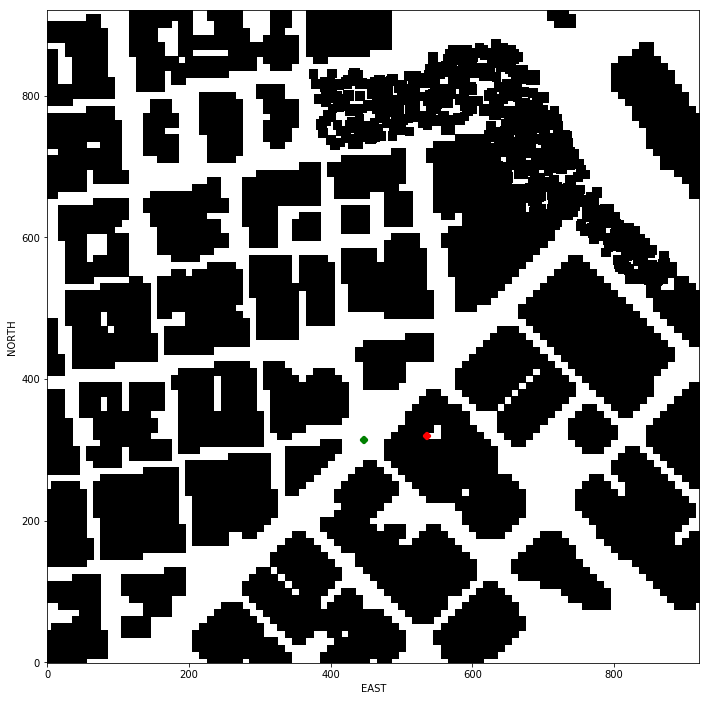

goal type: <class 'tuple'>, start type:<class 'tuple'>
D, DA: 1000 22807 CC: 35.92407448406448 HC: 68.09151861310727 QC: 104.01559309717175 CN: (319, 475, 12)
D, DA: 2000 47310 CC: 37.79898987322332 HC: 66.21660322394843 QC: 104.01559309717175 CN: (316, 477, 14)
D, DA: 4000 87939 CC: 29.752501608810682 HC: 74.26309148836108 QC: 104.01559309717177 CN: (319, 468, 14)
D, DA: 12000 174222 CC: 18.120955864630133 HC: 87.16598621332476 QC: 105.28694207795489 CN: (314, 460, 6)
D, DA: 14000 192757 CC: 34.853006672199 HC: 70.81944067446514 QC: 105.67244734666414 CN: (323, 476, 3)
D, DA: 15000 209561 CC: 23.166715171183775 HC: 82.75590139716269 QC: 105.92261656834646 CN: (313, 461, 15)
D, DA: 19000 256884 CC: 25.827698166887174 HC: 80.73059289185085 QC: 106.55829105873802 CN: (312, 465, 11)
D, DA: 21000 273312 CC: 35.21247447773741 HC: 71.63494553253256 QC: 106.84742001026996 CN: (312, 469, 24)
D, DA: 22000 286118 CC: 7.560477932315067 HC: 99.57679998734585 QC: 107.13727791966092 CN: (319, 446, 6

D, DA: 167000 1954396 CC: 42.702613556045996 HC: 81.17084391739479 QC: 123.8734574734408 CN: (317, 458, 37)
D, DA: 168000 1964902 CC: 75.34022991907148 HC: 48.63348761681452 QC: 123.973717535886 CN: (348, 502, 16)
D, DA: 170000 1995216 CC: 27.317108287336765 HC: 96.75857222765568 QC: 124.07568051499244 CN: (338, 454, 5)
D, DA: 176000 2055934 CC: 32.82842712474619 HC: 91.87831517751084 QC: 124.70674230225703 CN: (318, 445, 32)
D, DA: 177000 2069036 CC: 74.84742001026989 HC: 49.9547246503623 QC: 124.8021446606322 CN: (349, 503, 10)
D, DA: 178000 2086173 CC: 40.708684174891005 HC: 84.14140666587193 QC: 124.85009084076293 CN: (340, 460, 26)
D, DA: 182000 2127143 CC: 73.52200215938134 HC: 51.72306435728782 QC: 125.24506651666917 CN: (347, 495, 33)
D, DA: 185000 2156229 CC: 44.051829925398614 HC: 81.53104068079222 QC: 125.58287060619082 CN: (336, 460, 31)
D, DA: 186000 2173463 CC: 58.26163357264301 HC: 67.3689382127354 QC: 125.63057178537841 CN: (350, 486, 10)
D, DA: 187000 2186049 CC: 62.03

In [ ]:
def plan_path(self, twoD=False):
    self.flight_state = States.PLANNING
    print("Searching for a path ...")
    TARGET_ALTITUDE = 5
    SAFETY_DISTANCE = 5
    VOXEL_SIZE = 1
    MAX_ALTITUDE = 250

    self.target_position[2] = TARGET_ALTITUDE

    # TODO: read lat0, lon0 from colliders into floating point values

    # TODO: set home position to (lon0, lat0, 0)

    # TODO: retrieve current global position

    # TODO: convert to current local position using global_to_local()

    print('global home {0}, position {1}, local position {2}'.format(self.global_home, self.global_position,
                                                                     self.local_position))
    # Read in obstacle map
    data = np.loadtxt('colliders.csv', delimiter=',', dtype='Float64', skiprows=2)
    if not twoD:
        voxmap = create_voxmap(data, safety_distance=SAFETY_DISTANCE, max_altitude=MAX_ALTITUDE, voxel_size=1)
    # Define a grid for a particular altitude and safety margin around obstacles
    grid, north_offset, east_offset = create_grid(data, TARGET_ALTITUDE, SAFETY_DISTANCE)
    print("North offset = {0}, east offset = {1}".format(north_offset, east_offset))

    # Define starting point on the grid (this is just grid center)
    with open('colliders.csv') as f:
        first_line = f.readline().strip()
    latlon = first_line.split(',')
    lon0 = float(latlon[0].strip().split(' ')[1])
    lat0 = float(latlon[1].strip().split(' ')[1])      
    #grid_start = (-north_offset, -east_offset)
    # TODO: convert start position to current position rather than map center
    self.set_home_position(lat0, lon0, 0)
    print((lon0, lat0), " vs ", (-north_offset, -east_offset))    
    print("lla: ",self._latitude, self._longitude, self._altitude)
    print("gh: ",self.global_home)
    print("gp: ",self.global_position)
    local_pos = global_to_local(self.global_position, global_home=self.global_home)
    print("lp:", local_pos)
    north, east, att = local_pos
    print("gsf: ", (north - north_offset), (east - east_offset))

    #2d
    #3d
    if twoD:
        grid_start = (int(np.rint(north - north_offset)), int(np.rint(east - east_offset)))
    else:
        grid_start = (int(np.rint(north - north_offset)), int(np.rint(east - east_offset)), int(np.rint(self.global_position[2])))
    
    #grid_start = (316, 475, 30)
    
    vox_start = (grid_start[0] // VOXEL_SIZE,
             grid_start[1] // VOXEL_SIZE,
             grid_start[2] // VOXEL_SIZE)    
    print("gs: ",grid_start)
    

    
    # Set goal as some arbitrary position on the grid
    #grid_goal = (-north_offset + 10, -east_offset + 10)
    # TODO: adapt to set goal as latitude / longitude position and convert
    # grid_goal = (grid_start[0] + 10, grid_start[1] + 10)
    #goal = (-122.400600, 37.793401, 0)
    #goal = (lat0 + 0.0001, lon0 + 0.00001, 0)
    dist_idx = 100.0
    goal_obs = True
    goal_try = 0
    goal_list = []
    voxel_shape = voxmap.shape
    print(voxel_shape)
    while goal_obs and goal_try < 100:
        goal_try += 1
        change = np.random.rand(3)
        change[1:2] -= 0.5
        print("change", change)
        goal = (self.global_position[0] + change[0] / dist_idx,
                self.global_position[1] + change[1] / (dist_idx),
                self.global_position[2] + change[2] * float(MAX_ALTITUDE))
        print("goal: ", goal)
        local_goal = global_to_local(goal, global_home=self.global_home)
        print("lg: ", local_goal)
        ng, eg, ag = local_goal
        print("ggf: ", (ng - north_offset), (eg - east_offset))
        #2d vs 3d
        if twoD:
            grid_goal = (int(np.rint(ng - north_offset)), int(np.rint(eg - east_offset)))
        else:
            grid_goal = (int(np.rint(ng - north_offset)), int(np.rint(eg - east_offset)), int(np.rint(goal[2])))

#         grid_goal = (310,500,100)
        
#         grid_goal = (grid_start[0] - 8,
#                      grid_start[1] + 50,
#                      grid_start[2] + 95)

        grid_goal = (grid_start[0] + 5,
                     grid_start[1] + 100,
                     grid_start[2] + 30)

        vox_goal = (grid_goal[0] // VOXEL_SIZE,
                     grid_goal[1] // VOXEL_SIZE,
                     grid_goal[2] // VOXEL_SIZE)
        
        if vox_goal[0] >= voxel_shape[0]:
            vox_goal = (voxel_shape[0] - 1, vox_goal[1], vox_goal[2])
        elif vox_goal[0] < 1:
            vox_goal = (1, vox_goal[1], vox_goal[2])
        if vox_goal[1] >= voxel_shape[1]:
            vox_goal = (grid_goal[0], voxel_shape[1] - 1, vox_goal[2])
        elif vox_goal[1] < 1:
            vox_goal = (vox_goal[0], 1, vox_goal[2])
                    
        if twoD:
            goal_obs = grid[grid_goal[0], grid_goal[1]]
        else:
            goal_obs = voxmap[vox_goal[0], vox_goal[1], vox_goal[2]]
        print("gg: ",grid_goal, " vg: ", vox_goal, goal_obs)
        if goal_obs:
            goal_list.append(grid_goal)
    
    #grid_goal = (grid_start[0] + 10, grid_start[1] + 10,0)    
    #print("gg: ",grid_goal, " vg: ", vox_goal)
    # Run A* to find a path from start to goal
    # TODO: add diagonal motions with a cost of sqrt(2) to your A* implementation
    # or move to a different search space such as a graph (not done here)
    print('Grid Start and Goal: ', grid_start, grid_goal)
    print('Vox Start and Goal: ', vox_start, vox_goal)
    plot(grid, grid_start, grid_goal, goal_list=goal_list)
    # 2d vs 3d
    if twoD:
        path, cost = a_star(grid, heuristic, grid_start, grid_goal)
    else:
        path, cost = a_star3D(voxmap, heuristic3D, grid_start, grid_goal)
    print(len(path), cost)
    plot(grid, grid_start, grid_goal, goal_list=[], path=path)
    
    pruned_path = prune_path(path)
    print(len(pruned_path))
    plot(grid, grid_start, grid_goal, goal_list=[], path=pruned_path)
        
    print("A* path:")
    for p in path:
        print(p, voxmap[p[0], p[1], p[2]])
        
    print("Pruned_path:")
    for p in pruned_path:
        print(p)
    #    print(p, p.cost, p.delta, (p.delta[0] + north_offset, p.delta[1] + east_offset, TARGET_ALTITUDE, 0))
    # TODO: prune path to minimize number of waypoints
    # TODO (if you're feeling ambitious): Try a different approach altogether!

    # Convert path to waypoints
    #waypoints = [[p[0] + north_offset, p[1] + east_offset, TARGET_ALTITUDE, 0] for p in path]
    if twoD:
        waypoints = [[p[0] + north_offset, p[1] + east_offset, TARGET_ALTITUDE, 0] for p in pruned_path]
    else:
        waypoints = [[p[0] + north_offset, p[1] + east_offset, p[2], 0] for p in path]
    
    # Set self.waypoints
    self.waypoints = waypoints
    # TODO: send waypoints to sim (this is just for visualization of waypoints)
    self.send_waypoints()
MotionPlanning.plan_path = plan_path
main()

In [ ]:
err

In [ ]:
main()

In [ ]:
data = np.loadtxt('colliders.csv', delimiter=',', dtype='Float64', skiprows=2)

In [ ]:
data = np.loadtxt('colliders.csv', delimiter=',', dtype='Float64', skiprows=0)

In [ ]:
#first_line = ""
with open('colliders.csv') as f:
    first_line = f.readline().strip()
print(first_line)    
latlon = first_line.split(',')
gs = float(latlon[0].strip().split(' ')[1])
ge = float(latlon[1].strip().split(' ')[1])
print(gs, ge)

In [ ]:
print(first_line.strip())